# HW 5 
## Question 2
### Hamidreza Aliakbary Khoyi
#### 810196514

calling all necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import numpy.matlib
import math 
from numpy import linalg as LA
from matplotlib import pyplot as plt
import collections

mounting to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This function returns map data that were read from Drive.

In [ ]:
def read_map():
    with open('/content/drive/My Drive/IS/IS_HW_5/ENV.map', 'r') as f:
        m = f.read()
    m = m.split("\n")
    n = int((len(m[0])+1)/2)
    map = np.zeros((n,n),dtype=int)
    for i in range(n):
        map[ i , : ] = np.array(m[ i ].split(",") , ndmin = 1 , dtype = int)
    return map

In [ ]:
map = read_map()

We can see an overall illustration of mapping data.

In [ ]:
 pd.DataFrame(map)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,0,2,2,2,2,2,2,2,2,2,2,2,2,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2,2,2,2,2,2,2,2,2,2,2,2,0
3,0,0,2,2,2,2,2,2,2,2,2,2,2,2,0
4,0,0,2,2,2,2,2,2,2,2,2,2,2,2,0
5,0,0,2,2,2,2,2,2,2,2,2,2,2,2,0
6,0,0,2,2,2,2,2,2,2,2,2,2,2,2,0
7,5,4,2,2,2,2,2,2,2,2,2,2,2,2,0
8,0,0,2,2,2,2,2,2,2,2,2,2,2,2,3
9,0,0,2,2,2,2,2,2,2,2,2,2,2,2,0


There are 5 diiferent cells in map, so there will be 6 different rewards to assign.

In [ ]:
np.unique(map)

array([0, 1, 2, 3, 4, 5])

Global variables that show how directions could be illustrated as integers in code.

In [ ]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

## Enviroment
This class will work parallel to agent that will give feedbacks about reward, next state, checking if state is Done, more information to transfer to agent. For more detail explanation, see comments.

In [ ]:
class Maze_ENV():
    def __init__ ( self , map , Rewards):
        self.map = map
        self.y_max = map.shape[1]
        self.x_max = map.shape[0]
        self.rewards = rewards
        self.cell_set = {}
        self.current_pos = (0,0)
        self.further_pos = (0,0)
        self.nS = map.shape[0]*map.shape[1]
        self.nA = 4
        self.terminal_state = (0,0)
        self.current_state = 0
        self.nearest = []
        self.itter = 0
        self.it = 0
    
        # First here, i assign map data based on cell type to dictionay values.

        n = np.unique( self.map )
        for i in n :
            self.cell_set[ i ] = []

        n = np.unique( self.map )
        for i in range( self.x_max ):
            for j in range( self.y_max ):
                self.cell_set[ self.map[ i , j ] ].append( ( i , j ) )
                if self.map[ i , j ] == 3 : # setting Terminal state if cell type is 3.
                    self.terminal_state = ( i , j )
        dist = {}
        # For having good exploring search in first-ish eppisodes, i rank cells that their type is 0 and near to terminal state, 
        #So in arrival episodes , iinitial states will be near to terminal state
        tstate = np.array(self.terminal_state)
        for i in range(len( self.cell_set[ 0 ] )):
            temp = np.array( self.cell_set[ 0 ][ i ] )
            if np.sum(np.abs( temp - tstate )) not in dist.keys():
                dist[ np.sum(np.abs( temp - tstate )) ] = []
                dist[ np.sum(np.abs( temp - tstate )) ].append(self.cell_set[ 0 ][ i ] )
            else :
                dist[ np.sum(np.abs( temp - tstate )) ].append( self.cell_set[ 0 ][ i ] )
        od = collections.OrderedDict(sorted(dist.items()))
        for u,v in od.items():
            if type(v[0]) == type((1,1)):
                for i in range(len(v)):
                    self.nearest.append(v[ i ])
            else:
                self.nearest.append(v)
        self.cell_set[ 6 ] = []
        # I set an extra type for cells , since there should be problems about time  needed to converge, we set a reward of -20 for every visited state.
        self.rewards[ 6 ] = -20

    # This function checkes If nect state is in boundry of table or not.
    def check_boundries( self , pos ):
        j = pos[0]
        i = pos[1]
        temp = True
        if i not in range(self.x_max) or j not in range(self.y_max):
            temp = False
        return temp
    # This function coverts 2 kind of state locatio, for example: (224)->(14,14) or (1,0)->(15)
    def convert( self , pos , cond = 'to axis' ):
        if cond == 'to axis' :
            pos -= 1
            i = pos%self.y_max 
            j = int( ( pos - i )/self.x_max )
            return ( i , j )
        elif cond == 'to index' :
            return pos[0]*self.y_max + pos[1] 
        else :
            raise print("INVALID CONDITION !")
    
    #This function tells what is nect state based on action we take.
    def move( self , action ):
        if action == UP :
            return ( self.current_pos[0] - 1 , self.current_pos[1])
        elif action == LEFT :
            return ( self.current_pos[0] , self.current_pos[1] - 1)
        elif action == RIGHT :
            return ( self.current_pos[0] , self.current_pos[1] + 1)
        elif action == DOWN :
            return ( self.current_pos[0]+1 , self.current_pos[1])
        else:
            raise print("WRONG ACTION WAS TAKEN!")

    # Based on next state , this will return rewards assigned to it.
    def return_reward( self ):
        for unq in self.cell_set.keys():
            if self.further_pos in self.cell_set[ unq ] :
                self.cell_set[ unq ].remove( self.further_pos )
                self.cell_set[ 6 ].append( self.further_pos )
                return self.rewards[ unq ]
                break

    # checks if next state is terminal state or not.
    def if_done( self ):
        if self.further_pos == self.terminal_state :
            return True
        else:
            return False

    # After knowing next state, this checks boundries and sets possible nest state.
    def next_state( self , action ):
        temp_next_state = self.move( action )
        if self.check_boundries( temp_next_state ):
            self.further_pos = temp_next_state
        else:
            self.further_pos = self.current_pos
        
    # resets Env.
    def reset( self , exploring_start = True ):
        self.cell_set = {}
        n = np.unique( self.map )
        for i in n :
            self.cell_set[ i ] = []
        n = np.unique( self.map )
        for i in range( self.x_max ):
            for j in range( self.y_max ):
                self.cell_set[ self.map[ i , j ] ].append( ( i , j ) )
                if self.map[ i , j ] == 3 :
                    self.terminal_state = ( i , j )
        self.cell_set[ 6 ] = []
        self.further_pos = (0,0)
        if exploring_start :
            self.current_pos = self.find_nearest()
            self.itter += 1
        else:
            self.current_pos = (0,0)
        self.current_state = self.convert(self.current_pos,'to index')

    # Based on windy world there will be an stochastic moving with possibility of 0.05 .
    def random_action( self , action ):
        temp = []
        for i in range( self.nA ):
            if i != action:
                temp.append( i )
        if np.random.uniform(0,1, 1) < 0.05 :
            return temp[ np.random.randint( 0 , len(temp))]
        else:
            return action

    # in fisr exploring start section, based on which episode we run this will count and explore based on rankes states.
    def find_nearest(self):
        d = (self.itter)
        if d < len(self.nearest):
            return self.nearest[ int(d) ]
        else:
            return (0,0)

    # based o which action was taken, return ( Next state , Reward , Done condition , More information)
    def step( self , action ):
        action = self.random_action( action )
        self.next_state( action )
        done = self.if_done()
        info = "action " + str(action ) + " was taken in state " + str(self.current_pos)
        reward = self.return_reward()
        state_prim = self.convert(self.further_pos,'to index')
        self.current_pos = self.further_pos
        return state_prim , reward , done , info

# Q Learning
This agent will work paralell to ENv and will learn based on Q-Learning algorithm. This class will get atributes such as discount factor and epsilon and enviroment,alpha, ... . There is 2 main conditions this class can wirk with, First is decaying or not , Second is choosing type which is either soft max or epsilon greedy.

In [ ]:
class Q_learning():
    def __init__ ( self , dscnt_fctr , n_episodes ,  epsilon , alpha , env , decaying = True , choose = 'soft max' ):
        self.epsilon =epsilon
        self.nS = env.nS
        self.nA = env.nA
        self.env = env
        self.Q = np.zeros((self.nS , self.nA))
        self.decaying = True
        self.alpha =alpha
        self.n_episodes = n_episodes
        self.reward_per_episode = []
        self.dscnt_fctr = dscnt_fctr
        self.policy=np.zeros((self.nS , self.nA))
        self.max_reward = 0
        self.action_state = []
        self.choose = choose

    def max_checker( self , cummulative_reward , s_a ):
        if cummulative_reward > self.max_reward :
            self.max_reward = cummulative_reward
            self.policy=np.zeros((self.nS , self.nA))
            self.action_state = []
            self.action_state = s_a
            for i in range(self.nS):
                self.policy = np.argmax( self.Q[ i , : ] )

    def decay( self ):
        self.alpha -= 1/(self.n_episodes+1)
        self.epsilon = (self.epsilon/(self.n_episodes+1))*(self.n_episodes-10)
    
    def e_greedy_choose( self , state ):
        temp = self.Q[ state , : ]
        best = np.argmax(temp)
        probs = (np.ones(self.nA)/self.nA)*self.epsilon
        probs[ best ] += 1 - self.epsilon
        return np.random.choice( self.nA , 1 , p = probs )[0]

    def soft_max_choose( self , state ):
        temp = self.Q[ state , : ]
        best = np.argmax(temp)
        probs = np.zeros(self.nA)
        for i in range(self.nA):
            probs[ i ] =np.exp( temp[ i ] )
        probs /= np.sum( probs )
        return np.random.choice( self.nA , 1 , p = probs )[0]

    def run(self):
        for eps in range(self.n_episodes):
            self.env.reset(exploring_start = True )
            done = False
            state = self.env.current_state
            reward_sum = 0
            i = 0
            a_s = []
            while not done:
                if self.choose == 'e greedy':
                    action = self.e_greedy_choose( state )
                if self.choose == 'soft max':
                    action = self.soft_max_choose( state )
                state_prim, reward, done, info = self.env.step(action)
                a_s.append( ( state , action ))
                try:
                    reward_sum += reward
                except :
                    print( reward )
                self.Q[ state , action ] += self.alpha*( reward + self.dscnt_fctr*self.Q[ state_prim , np.argmax( self.Q[ state_prim , : ] ) ] - self.Q[ state , action ] )
                state = state_prim
                i += 1
                if done:
                    if eps >100:
                        self.max_checker( reward_sum , a_s )
                    self.reward_per_episode.append(reward_sum)
                    break
            if self.decaying :
                self.decay()

# SARSA
This class is based on SARSA algorithm which can perform better in stochastic windy world than Q-Learning, and this is fast.

In [ ]:
class SARSA():
    def __init__ ( self , dscnt_fctr , n_episodes ,  epsilon , alpha , env , decaying = True ):
        self.epsilon =epsilon
        self.nS = env.nS
        self.nA = env.nA
        self.env = env
        self.Q1 = np.zeros((self.nS , self.nA))
        self.decaying = True
        self.alpha =alpha
        self.n_episodes = n_episodes
        self.reward_per_episode = []
        self.dscnt_fctr = dscnt_fctr
        self.episode_lengths = []
        self.action_state = []
        self.max_reward = 0

    def decay( self ):
        self.alpha -= 1/(self.n_episodes+1)
    
    def e_greedy_choose( self , state ):
        temp = self.Q1[ state , : ]
        best = np.argmax(temp)
        probs = (np.ones( self.nA)/self.nA)*self.epsilon
        probs[ best ] += 1 - self.epsilon
        return np.random.choice( self.nA , 1 , p = probs )[0]

    def max_checker( self , cummulative_reward , s_a ):
        if cummulative_reward > self.max_reward :
            self.max_reward = cummulative_reward
            self.policy=np.zeros((self.nS , self.nA))
            self.action_state = []
            self.action_state = s_a
            for i in range(self.nS):
                self.policy = np.argmax( self.Q1[ i , : ] )

    def run(self):
        for eps in range(self.n_episodes):
            self.env.reset(exploring_start = True)
            done = False
            state = self.env.current_state
            reward_sum = 0
            action = self.e_greedy_choose( state )
            episode_length = 0 
            action_state = []
            while not done:
                state_prim, reward, done, info = self.env.step(action)
                reward_sum += reward
                action_prim = self.e_greedy_choose( state_prim )
                self.Q1[ state , action ] += self.alpha*( reward + self.dscnt_fctr*self.Q1[ state_prim , action_prim] - self.Q1[ state , action ] )
                action_state.append((state,action))
                state = state_prim
                action = action_prim
                episode_length += 1
                if done :
                    if eps>100:
                        self.max_checker( reward_sum , action_state )
                    self.episode_lengths.append( episode_length )
                    self.reward_per_episode.append(reward_sum)
                    break
            if self.decaying :
                self.decay()

#Testing Q-Learning

Building enviroment with rewardd of 0 for 4th cell type.

---



In [ ]:
rewards = {0:-0.01,1:0,2:-20,3:100,4:0,5:-100}
env = Maze_ENV( map , rewards )

In [ ]:
dq = Q_learning( 0.9 , 30000 ,  0.01 , 1 , env , decaying = True )
dq.run()

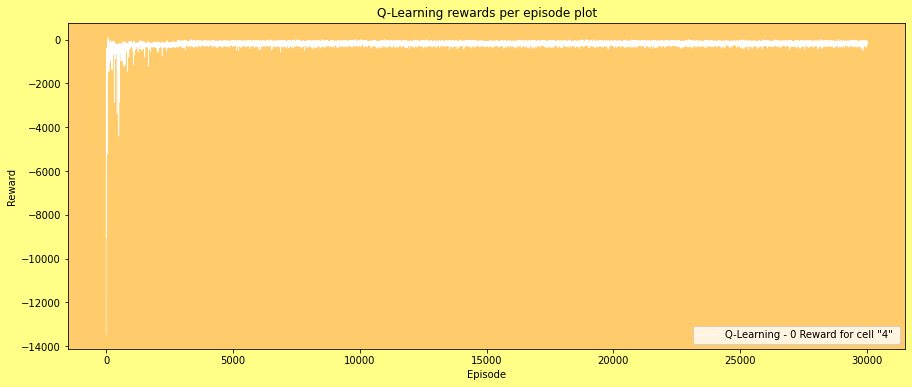

In [ ]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(dq.reward_per_episode , color='white',linewidth=0.6)
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('Q-Learning rewards per episode plot')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(['Q-Learning - 0 Reward for cell "4" ' ], loc='lower right')
plt.show()

In [ ]:
Route_QL_0 = dq.action_state

In [ ]:
dq.max_reward

99.79

Building enviroment with rewardd of 30 for 4th cell type.

In [ ]:
rewards = {0:-0.01,1:0,2:-20,3:100,4:30,5:-100}
env = Maze_ENV( map , rewards )

In [ ]:
dq_2 = Q_learning( 0.9 , 3000 ,  0.03 , 1 , env , decaying = True  )
dq_2.run()

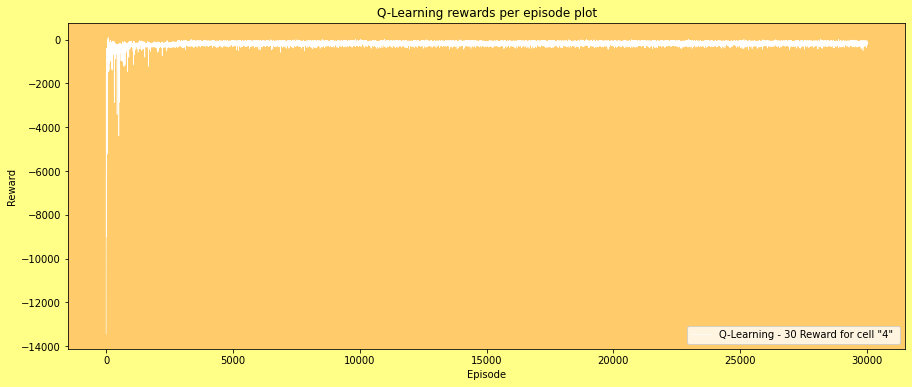

In [ ]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(dq.reward_per_episode , color='white',linewidth=0.6)
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('Q-Learning rewards per episode plot')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(['Q-Learning - 30 Reward for cell "4" ' ], loc='lower right')
plt.show()

In [ ]:
Route_QL_30 = dq_2.action_state

In [ ]:
dq_2.max_reward

219.77


# Testing SARSA

Building enviroment with rewardd of 0 for 4th cell type.

In [ ]:
rewards = {0:-0.01,1:0,2:-20,3:100,4:0,5:-100}
env = Maze_ENV( map , rewards )

In [ ]:
sarsa = SARSA( 0.9 , 3000 ,  0.001 , 1 , env , decaying = True )
sarsa.run()

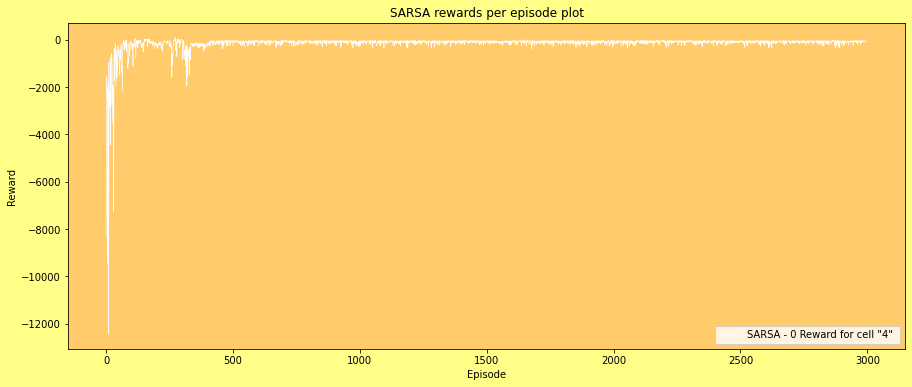

In [ ]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(sarsa.reward_per_episode , color='white',linewidth=0.6)
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('SARSA rewards per episode plot')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(['SARSA - 0 Reward for cell "4" ' ], loc='lower right')
plt.show()

In [ ]:
sarsa_r0 = sarsa.action_state

Building enviroment with reward of 30 for 4th cell type.

In [ ]:
rewards = {0:-0.01,1:0,2:-20,3:100,4:30,5:-100}
env = Maze_ENV( map , rewards )

In [ ]:
sarsa = SARSA( 0.9 , 3000 ,  0.01 , 1 , env , decaying = True )
sarsa.run()

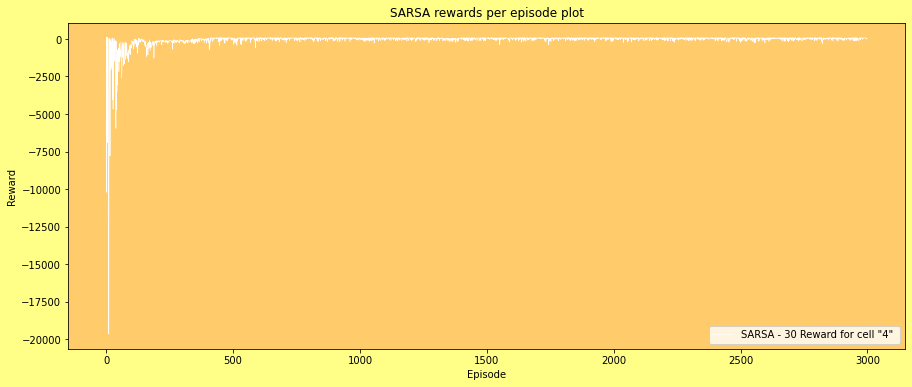

In [ ]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(sarsa.reward_per_episode , color='white',linewidth=0.6)
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('SARSA rewards per episode plot')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(['SARSA - 30 Reward for cell "4" ' ], loc='lower right')
plt.show()

In [ ]:
sarsa_r30 = sarsa.action_state

# Animation for Best episode were taken in each method.

 Q-Learning with reward 0

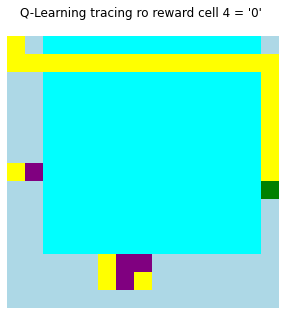

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors
from IPython.display import HTML

temp = read_map()
way = []
for i in range( len( Route_QL_0 ) ):
    way.append( Route_QL_0[ i ][ 0 ] )

cmap = colors.ListedColormap(['lightblue', 'black', 'white', 'cyan', 'Green','black','purple','yellow'])


def change(state):
    global temp
    x = state%temp.shape[0]
    y = ( state - x )/temp.shape[0]
    temp[ int(y) , int(x)  ] = 7

def update( i ):
    global way
    change( way[ i ] )

    mat.set_data(temp)
    return [mat]

fig, ax = plt.subplots(figsize=(5, 5));

ax.grid(False)
plt.axis('off')
plt.title("Q-Learning tracing ro reward cell 4 = '0' ")

mat = ax.matshow(temp, cmap=cmap)
ani = animation.FuncAnimation(fig, update, frames = len(way), interval = 400, repeat=True)


rc('animation', html='jshtml')
ani

 Q-Learning with reward 30

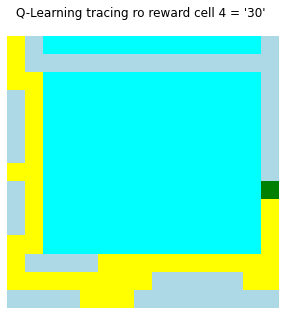

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors
from IPython.display import HTML

temp = read_map()
way = []
for i in range( len( Route_QL_30 ) ):
    way.append( Route_QL_30[ i ][ 0 ] )

cmap = colors.ListedColormap(['lightblue', 'black', 'white', 'cyan', 'Green','black','purple','yellow'])


def change(state):
    global temp
    x = state%temp.shape[0]
    y = ( state - x )/temp.shape[0]
    temp[ int(y) , int(x)  ] = 7

def update( i ):
    global way
    change( way[ i ] )

    mat.set_data(temp)
    return [mat]

fig, ax = plt.subplots(figsize=(5, 5));

ax.grid(False)
plt.axis('off')
plt.title("Q-Learning tracing ro reward cell 4 = '30' ")

mat = ax.matshow(temp, cmap=cmap)
ani = animation.FuncAnimation(fig, update, frames = len(way), interval = 400, repeat=True)


rc('animation', html='jshtml')
ani

SARSA with reward 0

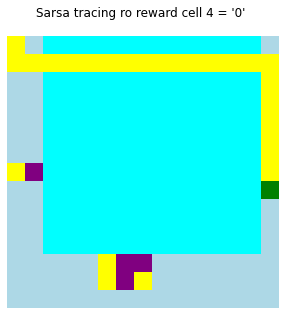

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors
from IPython.display import HTML

temp = read_map()
way = []
for i in range( len( sarsa_r0 ) ):
    way.append( sarsa_r0[ i ][ 0 ] )

cmap = colors.ListedColormap(['lightblue', 'black', 'white', 'cyan', 'Green','black','purple','yellow'])


def change(state):
    global temp
    x = state%temp.shape[0]
    y = ( state - x )/temp.shape[0]
    temp[ int(y) , int(x)  ] = 7

def update( i ):
    global way
    change( way[ i ] )

    mat.set_data(temp)
    return [mat]

fig, ax = plt.subplots(figsize=(5, 5));

ax.grid(False)
plt.axis('off')
plt.title("Sarsa tracing ro reward cell 4 = '0' ")

mat = ax.matshow(temp, cmap=cmap)
ani = animation.FuncAnimation(fig, update, frames = len(way), interval = 400, repeat=True)


rc('animation', html='jshtml')
ani

SARSA with reward 30

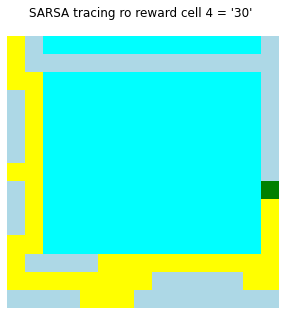

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors
from IPython.display import HTML

temp = read_map()
way = []
for i in range( len( sarsa_r30 ) ):
    way.append( sarsa_r30[ i ][ 0 ] )

cmap = colors.ListedColormap(['lightblue', 'black', 'white', 'cyan', 'Green','black','purple','yellow'])


def change(state):
    global temp
    x = state%temp.shape[0]
    y = ( state - x )/temp.shape[0]
    temp[ int(y) , int(x)  ] = 7

def update( i ):
    global way
    change( way[ i ] )

    mat.set_data(temp)
    return [mat]

fig, ax = plt.subplots(figsize=(5, 5));

ax.grid(False)
plt.axis('off')
plt.title("SARSA tracing ro reward cell 4 = '30' ")

mat = ax.matshow(temp, cmap=cmap)
ani = animation.FuncAnimation(fig, update, frames = len(way), interval = 400, repeat=True)


rc('animation', html='jshtml')
ani

# Comparing e-greedy and softmax

The softmax function is used in various multiclass classification methods, such as multinomial logistic regression (also known as softmax regression) , That illustrates probablities based on Q-value more. such that it makes difference bold that gives more probablity to best Q-values than e-greedy and less probablity to worst Q-value than e-greedy.


In over all view, Softmax because of this on-blind taking action, works signicantly better than e-greedy.

There is a temprature as hyper parameter in softmax that we can tune it through episodes to control exploring-exploiting balance.

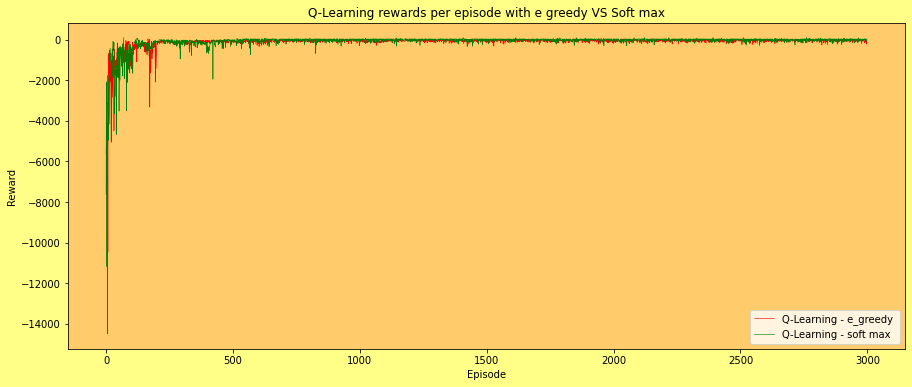

In [ ]:
dq_1 = Q_learning( 0.9 , 3000 ,  0.01 , 1 , env , decaying = True , choose='e greedy')
dq_1.run()
dq_2 = Q_learning( 0.9 , 3000 ,  0.01 , 1 , env , decaying = True )
dq_2.run()
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(dq_1.reward_per_episode , color='Red',linewidth=0.6)
ax.plot(dq_2.reward_per_episode , color='Green',linewidth=0.6)
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('Q-Learning rewards per episode with e greedy VS Soft max')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(['Q-Learning - e_greedy ' , 'Q-Learning - soft max '], loc='lower right')
plt.show()

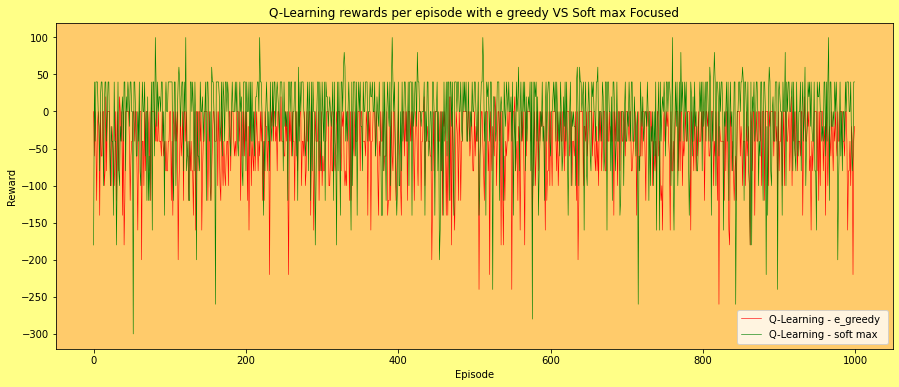

In [ ]:
fig = plt.figure(figsize=(15,6))
fig.patch.set_facecolor('yellow')
fig.patch.set_alpha(0.47)
ax = fig.add_subplot(111)
ax.plot(dq_1.reward_per_episode[2000:] , color='Red',linewidth=0.6)
ax.plot(dq_2.reward_per_episode[2000:] , color='Green',linewidth=0.6)
ax.patch.set_facecolor('red')
ax.patch.set_alpha(0.2)
plt.title('Q-Learning rewards per episode with e greedy VS Soft max Focused')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(['Q-Learning - e_greedy ' , 'Q-Learning - soft max '], loc='lower right')
plt.show()

In [ ]:
r1= dq_1.action_state

In soft max because of epsilon-flow-control in terms of episode growing, there is flaws in taking route to terminal state based in best episode in e-greedy.

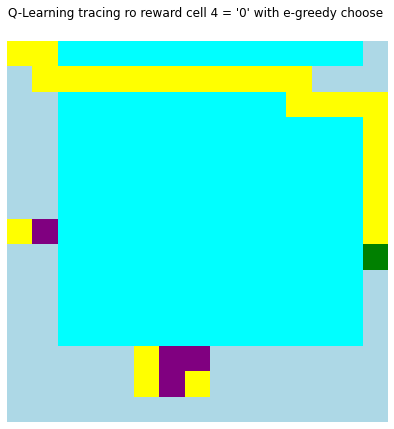

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors
from IPython.display import HTML

temp = read_map()
way = []
for i in range( len( r1 ) ):
    way.append( r1[ i ][ 0 ] )

cmap = colors.ListedColormap(['lightblue', 'black', 'white', 'cyan', 'Green','black','purple','yellow'])


def change(state):
    global temp
    x = state%temp.shape[0]
    y = ( state - x )/temp.shape[0]
    temp[ int(y) , int(x)  ] = 7

def update( i ):
    global way
    change( way[ i ] )

    mat.set_data(temp)
    return [mat]

fig, ax = plt.subplots(figsize=(7, 7));

ax.grid(False)
plt.axis('off')
plt.title("Q-Learning tracing ro reward cell 4 = '0' with e-greedy choose ")

mat = ax.matshow(temp, cmap=cmap)
ani = animation.FuncAnimation(fig, update, frames = len(way), interval = 400, repeat=True)


rc('animation', html='jshtml')
ani